## Image Captioning 
- Genrating Captions for Images

## Steps
- Data collection
- Understanding the data
- Data Cleaning
- Loading the training set
- Data Preprocessing — Images
- Data Preprocessing — Captions
- Data Preparation using Generator Function
- Word Embeddings
- Model Architecture
- Inference
- Evaluation

## Read Caption/ Data Collection
There are many open source datasets available for this problem, like Flickr 8k
(containing8k images), Flickr 30k (containing 30k images), MS COCO (containing
180k images), etc.

I've used flickr8k dataset that is available on kaggle. You can
run download_data.sh shell script. Before that put kaggle.json which is kaggle api
key in same directory.
This dataset contains 8000 images each with 5 captions (as we have already seen in
the Introduction section that an image can have multiple captions, all being relevant
simultaneously).

These images are bifurcated as follows:
- Training Set — 6000 images
- Dev Set — 1000 images
- Test Set — 1000 images

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add

In [3]:
def readText(path):
    with open(path) as f:
        caption = f.read()
    return caption

In [9]:
caption = readText("D:\\Desktop\\Flickr_Data\\Flickr_TextData\\Flickr8k.token.txt")

In [5]:
## Length of the Caption text Data
caption = caption.split("\n")
print(len(caption))

40461


## Print Caption

In [6]:
caption[0]

'1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .'

In [7]:
caption[-1]

''

<b>So Last Caption is empty. To Clean and achive accurate data, We can discard id by performing sclicing operation. </b>

In [10]:
caption = caption.split("\n")[:-1]

In [11]:
## Now, Length of the Caption text Data
print(len(caption))

40460


In [12]:
caption[-1]

'997722733_0cb5439472.jpg#4\tA rock climber practices on a rock climbing wall .'

## Understanding the data
If you have downloaded the data from the Kaggle that I have provided, then, along with images, you will also get some text files related to the images. One of the files
is “Flickr8k.token.txt” which contains the name of each image along with its 5
captions. 

To read the 5 caption for a Sigle Image We have to create the Dictinary to map each Image with List of Caption It has...

In [13]:
discription = {}

for x in caption:
    first,second = x.split("\t")
    img_name = first.split(".")[0]
    # if image id is already exist or not
    if discription.get(img_name) is None:
        discription[img_name] = []
    discription[img_name].append(second)

In [14]:
## We can read this file as follows : 
discription['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

## Fatch Images 

In [15]:
import cv2
import matplotlib.pyplot as plt 

In [16]:
img = cv2.imread("D:\\Desktop\\Flickr_Data\\Images\\1000268201_693b08cb0e.jpg")

<function matplotlib.pyplot.show(close=None, block=None)>

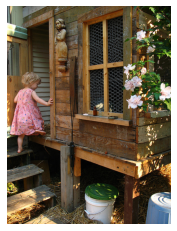

In [17]:
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.show

So, We can Conclude that Our modle will give 5 caption is seem to be correct which is in Image.

## Data Cleaning
To clean the sentences We usualy perform some NLTK library function like - Stopeword removel, Stemming etc. same as we perform in Sentiment analysis. But here we can not perform these operation here. because we have to manage grammer meaning of the sentences for Eg. if we perform stemming on example "Running" it will make Run which will come out different meaning for the caption.

Here When we deal with text, we generally perform some basic cleaning like lowercasing all the words (otherwise “hello” and “Hello” will be regarded as two separate
words), removing special tokens (like ‘%’, ‘$’, ‘#’, etc.), eliminating words which
contain numbers (like ‘hey199’, etc.).


In [18]:
import re
def Clean_text(Sentence):
    Sentence = Sentence.lower()
    Sentence = re.sub("[^a-z]+"," ",Sentence)
    Sentence = Sentence.split()
    
    Sentence = [s for s in Sentence if (len(s)>1)]
    Sentence = " ".join(Sentence)
    return Sentence

In [19]:
## Check Function for sample Eg.
Clean_text("A cat is sitting over the house #64")

'cat is sitting over the house'

In [20]:
## Clean All the Caption

In [21]:
for key,caption_list in discription.items(): # treated as key, value = key,caption_list
    for i in range(len(caption_list)): # treverse all the 5 caption of single image
        caption_list[i] = Clean_text(caption_list[i])

In [22]:
discription['1000268201_693b08cb0e'] # Check for an image 

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

## Create a vocabulary 
Create a vocabulary of all the unique words present across all the 8000*5 (i.e. 40000) image captions (corpus) in the data set However, if we think about it, many of these words will occur very few times, say 1, 2 or 3 times. Since we are creating a predictive model, we would not like to have all the words present in our vocabulary but the words which are more likely to occur or which are common. This helps the model become more robust to outliers and make less mistakes.

In [23]:
vocabulary  = set()
for key in discription.keys():
    [vocabulary .update(sentence.split()) for sentence in discription[key]]
print("vocabulary  Size : %d" % len(vocabulary ))
    

vocabulary  Size : 8424


In [24]:
## Total number of Words acroos all the Sentences 
total_words = []
for key in discription.keys():
    [total_words.append(i) for des in discription[key] for i in des.split()]
print("Total Words %d"%len(total_words))

Total Words 373837


In [25]:
print(total_words[:10])

['child', 'in', 'pink', 'dress', 'is', 'climbing', 'up', 'set', 'of', 'stairs']


In [26]:
# Hence we consider only those words which occur at least 10 times in the entire corpus. The code for this is below
# Filter Words from the Vocab according to Certaion treshhold frequency

In [27]:
import collections
from collections import Counter
Counter = collections.Counter(total_words)
freq_cnt = dict(Counter)
print (len(freq_cnt.keys())) # this shows that how many time word is occuring 

8424


In [28]:
# Sort this dictonary according to the freq Count

In [36]:
sorted_freq_cnt = sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1])

#Filtering
threshold = 10
sorted_freq_cnt = [x for x in sorted_freq_cnt if x[1]>threshold]
total_word = [x[0] for x in sorted_freq_cnt]

In [40]:
print(len(total_word)) # Show Sorted >freq uniqe words

1845


So We have started with somewhere arount 317000 words and to perfor preproceesing opretion we have left 1845 words

So now we have only 1845 unique words in our vocabulary. However, we will append 0’s (zero padding explained later) and thus total words = 1845+1 = 1846 (one index for the 0).



## Prepare Train/Test Data

## Read Files

In [50]:
train_file_data = readText("D:\\Desktop\\Flickr_Data\\Flickr_TextData\\Flickr_8k.trainImages.txt")
test_file_data = readText("D:\\Desktop\\Flickr_Data\\Flickr_TextData\\Flickr_8k.testImages.txt")

In [51]:
train = [row.split(".")[0] for row in train_file_data.split("\n")[:-1] ]
test = [row.split(".")[0] for row in test_file_data.split("\n")[:-1] ]

In [52]:
train[:5]

['2513260012_03d33305cf',
 '2903617548_d3e38d7f88',
 '3338291921_fe7ae0c8f8',
 '488416045_1c6d903fe0',
 '2644326817_8f45080b87']

In [ ]:
# Now Prepare Description for Training Data 
# Tweak - Add <s> and <e> token to our training data
train_description = {}
for img_id in train:
    train_description[img_id] = []
    for cap in discription[img_id]:
        cap_append = "startseq " + cap + " endseq"
        train_description[img_id].append(cap_append)

In [63]:
train_description['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

## Image  Preprocessing